In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm import tqdm
import seaborn as sns
import re
import datetime
import os
import random
import h3 
import shap 

c:\Users\Yuan\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
h3_l7_df = pd.read_csv('h3_l7_df_new.csv')
h3_l7_df.drop(columns=['commercial;yes'], inplace=True)
h3_l7_df

,id,place_of_worship,grave_yard,school,post_office,childcare,university,courthouse,fire_station,library,...,warehouse,sports_centre,detached,boathouse,barn,riding_hall,construction,ship,ruins,ohca
0,872af0424ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,872af0425ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,872af0426ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,872af0500ffffff,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,872af0501ffffff,0,0,1,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,872af6373ffffff,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
173,872af6375ffffff,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,20
174,872af6acaffffff,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
175,872af6ad9ffffff,2,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,2


In [3]:
h3_l7_df = pd.read_csv('h3_l7_df_new.csv')
h3_l7_df.drop(columns=['commercial;yes'], inplace=True)

train_index=[]
test_index=[]
for i in range(0,h3_l7_df.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = h3_l7_df.iloc[train_index]
test_h3_l7_df = h3_l7_df.iloc[test_index]

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

# 分离特征和标签
X = spatial_data[:, :-1]  # 特征
Y = spatial_data[:, -1]   # 标签（OHCA）

X_train_reguli = train_spatial_data[:, :-1] 
y_train_reguli = train_spatial_data[:, -1] 
X_test_reguli = test_spatial_data[:, :-1] 
y_test_reguli = test_spatial_data[:, -1] 

In [4]:
# 定義XGBoost模型並指定參數
best_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=277,
    early_stopping_rounds=10,
    # 以下是您指定的參數值，請根據需要修改這些值
    max_depth=3,               # 樹的最大深度
    learning_rate=0.2,         # 學習率
    n_estimators=100,          # 樹的數量
    subsample=0.7,            # 每棵樹隨機採樣的比例 0.7
    colsample_bytree=0.7,      # 每棵樹使用的特徵比例 0.7
    gamma=0,                # 控制節點分裂的最小增益
    reg_alpha=0.1,            # L1正則化強度 0
    reg_lambda=1,           # L2正則化強度
    min_child_weight=3        # 每個葉子節點的最小樣本權重
)
# 訓練模型
best_xgb_model.fit(
    X_train_reguli, y_train_reguli,
    eval_set=[(X_test_reguli, y_test_reguli)],  # 提供測試集進行早停監控
    verbose=True
)

# 預測訓練集結果
y_head_train = best_xgb_model.predict(X_train_reguli) * ohca_reguli_inverse
y_train = y_train_reguli * ohca_reguli_inverse
# 預測測試集結果
y_head_test = best_xgb_model.predict(X_test_reguli) * ohca_reguli_inverse
y_test = y_test_reguli * ohca_reguli_inverse


#評估成效
train_mae = np.abs(y_head_train-y_train)
train_ans_mae = train_mae.sum()/train_mae.shape[0]
print('MAE of train set= ',train_ans_mae)
# 計算殘差變異
train_ss_residual = np.sum((y_train - y_head_train) ** 2)
# 計算總變異量
train_ss_total = np.sum((y_train - np.mean(y_train)) ** 2)
# 計算 R²
train_r_squared = 1 - (train_ss_residual / train_ss_total)
print("R² of train set= ", train_r_squared)

test_mae = np.abs(y_head_test-y_test)
test_ans_mae = test_mae.sum()/test_mae.shape[0]
print('MAE of test set= ',test_ans_mae)
# 計算殘差變異
test_ss_residual = np.sum((y_test - y_head_test) ** 2)
# 計算總變異量
test_ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
# 計算 R²
test_r_squared = 1 - (test_ss_residual / test_ss_total)
print("R² of test set= ", test_r_squared)

[0]	validation_0-rmse:0.24953
[1]	validation_0-rmse:0.22717
[2]	validation_0-rmse:0.21675
[3]	validation_0-rmse:0.19437
[4]	validation_0-rmse:0.17980
[5]	validation_0-rmse:0.17177
[6]	validation_0-rmse:0.16906
[7]	validation_0-rmse:0.16359
[8]	validation_0-rmse:0.15430
[9]	validation_0-rmse:0.14877
[10]	validation_0-rmse:0.14466
[11]	validation_0-rmse:0.14188
[12]	validation_0-rmse:0.14336
[13]	validation_0-rmse:0.14145
[14]	validation_0-rmse:0.13830
[15]	validation_0-rmse:0.13515
[16]	validation_0-rmse:0.13363
[17]	validation_0-rmse:0.13014
[18]	validation_0-rmse:0.12816
[19]	validation_0-rmse:0.12567
[20]	validation_0-rmse:0.12576
[21]	validation_0-rmse:0.12480
[22]	validation_0-rmse:0.12508
[23]	validation_0-rmse:0.12501
[24]	validation_0-rmse:0.12522
[25]	validation_0-rmse:0.12447
[26]	validation_0-rmse:0.12380
[27]	validation_0-rmse:0.12462
[28]	validation_0-rmse:0.12306
[29]	validation_0-rmse:0.12252
[30]	validation_0-rmse:0.12137
[31]	validation_0-rmse:0.12029
[32]	validation_0-

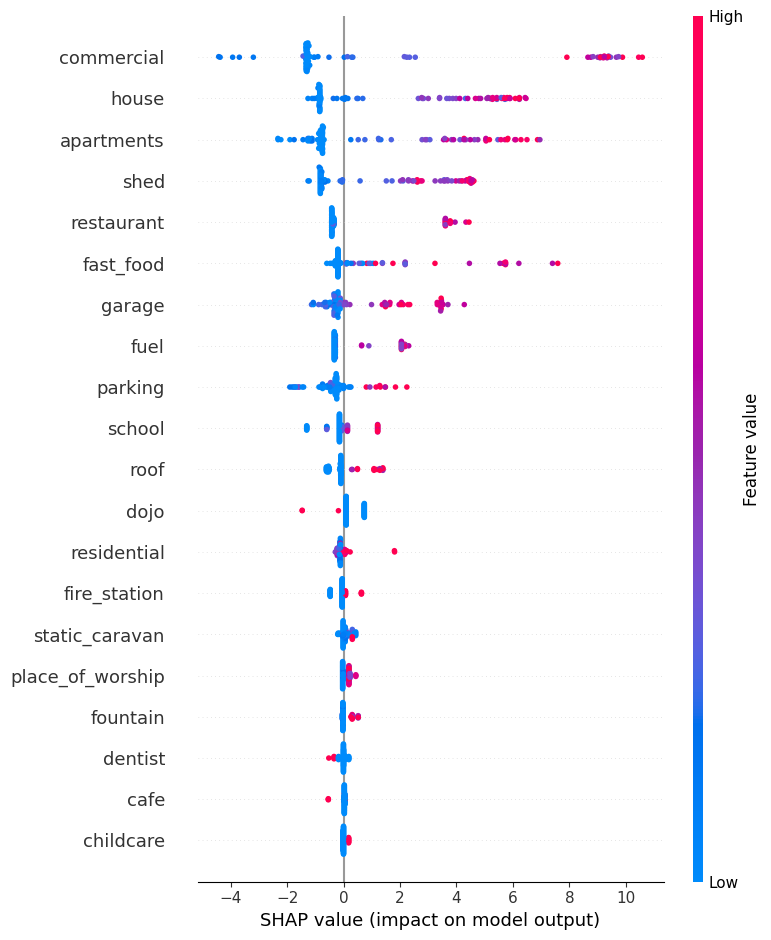

In [5]:
import shap
import matplotlib.pyplot as plt

# 初始化 SHAP 解釋器
explainer = shap.TreeExplainer(best_xgb_model)

# 計算 SHAP 值 (對測試集數據進行解釋)
shap_values_test = explainer.shap_values(X_test_reguli)*ohca_reguli_inverse

# Get the shap values from my test data
test_features_df = h3_spatial_data.iloc[:, :-1]
feature_names = test_features_df.columns

shap.summary_plot(shap_values_test, X_test_reguli,feature_names, max_display=20)
# # 顯示每個特徵的平均影響力 (特徵重要性條形圖)
# shap.summary_plot(shap_values_test, X_test_reguli,feature_names,max_display=X_test_reguli.shape[1])

# 製造有SHAP值的poi_df

In [6]:
feature_names_w_SHAP = [f'shap {col}' for col in feature_names] # 在每個列名前加上 'shap'
SHAP_df = pd.DataFrame(shap_values_test, columns=feature_names_w_SHAP) #換成 DF

df1 = test_h3_l7_df.reset_index(drop=True)
df2 = SHAP_df.reset_index(drop=True)
test_h3_l7_df_S = pd.concat([df1, df2], axis=1) #合併SHAP值到test_h3_l7_df

In [7]:
# 初始化結果 DataFrame
spatial_data_score = pd.DataFrame()
spatial_data_score['id'] = test_h3_l7_df_S['id']

# 初始化字典來存儲計算結果
results_dict = {}
# 逐列處理
for col in feature_names:
    col_result = []  # 存儲當前特徵的計算結果
    
    # 遍歷每一行
    for row in range(test_h3_l7_df_S.shape[0]):
        building_name = col
        shap_name = 'shap ' + building_name
        denominator = test_h3_l7_df_S.iloc[row][building_name] # 分母
        numerator = test_h3_l7_df_S.iloc[row][shap_name]  # 分子
        
        # 處理分母為 0 的情況
        if denominator == 0:
            col_result.append(numerator)
        else:
            col_result.append(numerator / denominator)

    # 將結果存入字典
    results_dict[col] = col_result

# 一次性加入所有計算結果
spatial_data_score = pd.concat([spatial_data_score, pd.DataFrame(results_dict)], axis=1)

In [8]:
spatial_data_score

,id,place_of_worship,grave_yard,school,post_office,childcare,university,courthouse,fire_station,library,...,cabin,warehouse,sports_centre,detached,boathouse,barn,riding_hall,construction,ship,ruins
0,872af0424ffffff,-0.033597,0.0,-0.146644,0.0,-0.002574,0.0,0.0,-0.048740,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,872af0425ffffff,-0.033597,0.0,-0.146644,0.0,-0.002574,0.0,0.0,-0.048740,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,872af0426ffffff,-0.033597,0.0,-0.146644,0.0,-0.002574,0.0,0.0,-0.048740,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,872af0502ffffff,-0.033597,0.0,-0.146644,0.0,-0.002574,0.0,0.0,-0.048740,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,872af0503ffffff,-0.033597,0.0,-0.146644,0.0,-0.002574,0.0,0.0,-0.048740,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,872af6370ffffff,0.045451,0.0,-0.146644,0.0,-0.018512,0.0,0.0,-0.473479,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,872af6371ffffff,0.112925,0.0,0.045129,0.0,-0.002574,0.0,0.0,-0.048740,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,872af6372ffffff,0.062881,0.0,-1.307091,0.0,0.177719,0.0,0.0,0.631305,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,872af6373ffffff,-0.033597,0.0,-0.146644,0.0,-0.002574,0.0,0.0,-0.048740,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 製造有SHAP值的poi_df

In [9]:
poi_df = pd.read_csv('poi_df.csv') #讀進原檔案
selected_values = spatial_data_score['id']
test_poi_df = poi_df[poi_df['h3_l7'].isin(selected_values)]

In [10]:
# Step 1: 將 spatial_data_score 的 wide-format 轉成 long-format
long_score_df = spatial_data_score.melt(
    id_vars='id',
    var_name='building',     # 建築類型欄
    value_name='score'       # 分數欄
)

# Step 2: 不預設 test_poi_df['score']，直接 merge
test_poi_df = test_poi_df.reset_index(drop=True)
test_poi_df = test_poi_df.merge(
    long_score_df,
    how='left',
    left_on=['h3_l7', 'building'],
    right_on=['id', 'building']
)

# Step 3: 清理合併後的中間欄位
test_poi_df.drop(columns=['id'], inplace=True)

# Step 4: 最後的 score 就是合併進來的，不會有 _x/_y 問題
test_poi_df


,osmid,lat,lon,h3_l7,building,score
0,356567877,36.709595,-76.047987,872af626dffffff,place_of_worship,0.112925
1,356567948,36.586005,-76.082863,872af051cffffff,place_of_worship,0.112925
2,356568033,36.733205,-76.097433,872af626effffff,place_of_worship,0.144269
3,356568069,36.557653,-76.073542,872af0519ffffff,place_of_worship,0.112925
4,356568361,36.850422,-76.160777,872af6353ffffff,place_of_worship,0.037729
...,...,...,...,...,...,...
99719,7485109,36.866139,-76.133943,872af6350ffffff,residential,0.000348
99720,9637418,36.858806,-76.170325,872af622cffffff,house,0.000097
99721,11674759,36.819752,-76.076312,872af634effffff,school,0.045129
99722,12032839,36.790276,-76.111886,872af6266ffffff,residential,0.001624


In [11]:
# test_poi_df = test_poi_df.reset_index(drop=True)
# test_poi_df['score'] = None  # 初始化 'score' 列為空值

# # 循環處理每一行
# for i in range(0, test_poi_df.shape[0]):
#     poi_id = test_poi_df['h3_l7'].iloc[i]  # 取得當前行的 poi_id
#     building_type = test_poi_df['building'].iloc[i]  # 取得當前行的 building_type
    
#     # 查找 spatial_data_score 中對應的 id 和 amenity
#     positions = spatial_data_score.index[spatial_data_score['id'] == poi_id]
 
#         # 檢查 building_type 是否在 spatial_data_score 的列中
#     if building_type in spatial_data_score.columns:
#         building_score = spatial_data_score.loc[positions, building_type]
        
#         if not building_score.empty:
#             # 如果找到了對應的建築分數，將其轉換為數字並儲存
#             test_poi_df.loc[i, 'score'] = pd.to_numeric(building_score.iloc[0])
#         else:
#             # 如果沒有找到對應的 building_type，可以設為 NaN 或其他預設值
#             test_poi_df.loc[i, 'score'] = None
#     else:
#         # 如果 building_type 不存在於 spatial_data_score，設為 NaN 或其他預設值
#         test_poi_df.loc[i, 'score'] = None


# # 檢查結果
# test_poi_df

In [12]:
def intersection_area(r1, r2, d):
    if d >= r1 + r2:
        return 0  # 兩圓不相交
    elif d <= abs(r1 - r2):
        return np.pi * min(r1, r2)**2  # 一圓包含另一圓
    else:
        # 使用公式計算相交面積
        term1 = r1**2 * np.arccos((d**2 + r1**2 - r2**2) / (2 * d * r1))
        term2 = r2**2 * np.arccos((d**2 + r2**2 - r1**2) / (2 * d * r2))
        term3 = 0.5 * np.sqrt((-d + r1 + r2) * (d + r1 - r2) * (d - r1 + r2) * (d + r1 + r2))
        return term1 + term2 - term3


In [13]:
import math
# 向量化 haversine 距離計算
def haversine_array(lat1, lon1, lat2_array, lon2_array):
    lat1, lon1 = map(math.radians, [lat1, lon1])
    lat2_array = np.radians(lat2_array)
    lon2_array = np.radians(lon2_array)
    
    dlat = lat2_array - lat1
    dlon = lon2_array - lon1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2_array) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    R = 6371.0
    return R * c

In [14]:
def cache_h3_centers(df, h3_col='h3_l7'):
    unique_h3 = df[h3_col].unique()
    h3_center_dict = {h: h3.h3_to_geo(h) for h in unique_h3}
    df['center_lat'] = df[h3_col].map(lambda h: h3_center_dict[h][0])
    df['center_lon'] = df[h3_col].map(lambda h: h3_center_dict[h][1])
    return df

test_poi_df = cache_h3_centers(test_poi_df)

In [15]:
def area_score(AED_location, AED_range):
    center_radius = 1.21

    distances = haversine_array(AED_location[0], AED_location[1], test_poi_df['lat'], test_poi_df['lon'])
    mask = (distances <= AED_range) & (test_poi_df['score'].notna())
    subset = test_poi_df.loc[mask].copy()
    subset['distance_to_AED'] = distances[mask]

    if subset.empty:
        return 0

    # 直接使用快取的中心點
    center_distances = haversine_array(
        AED_location[0], AED_location[1],
        subset['center_lat'], subset['center_lon']
    )

    intersection_areas = [intersection_area(AED_range, center_radius, d) for d in center_distances]
    proportions = np.array(intersection_areas) / (np.pi * center_radius ** 2)
    weighted_scores = subset['score'].values * proportions

    return weighted_scores.sum()


In [16]:
area_score((36.7332054, -76.0974333), 1.21)

-2.2843110437108587

In [17]:
from tqdm import tqdm

total_score_list = []
for index in tqdm(range(test_poi_df.shape[0]), desc="Calculating total_score"):
    lat, lon = test_poi_df.iloc[index]['lat'], test_poi_df.iloc[index]['lon']
    total_score = area_score((lat, lon), 1.21)
    # print(total_score)
    total_score_list.append(total_score)
    

test_poi_df['total_score'] = total_score_list

Calculating total_score: 100%|██████████| 99724/99724 [52:07<00:00, 31.89it/s]  


# OR input XGB relsult only

In [18]:
test_h3_l7_df['y_head'] = y_head_test
h3_center_dict = {h: h3.h3_to_geo(h) for h in test_h3_l7_df['id']}
test_h3_l7_df['center_lat'] = test_h3_l7_df['id'].map(lambda h: h3_center_dict[h][0])
test_h3_l7_df['center_lon'] = test_h3_l7_df['id'].map(lambda h: h3_center_dict[h][1])

def area_score_mlp(AED_location, AED_range):
    center_radius = 1.21

    distances = haversine_array(AED_location[0], AED_location[1], test_h3_l7_df['center_lat'], test_h3_l7_df['center_lon'])
    mask = (distances <= AED_range * 2)
    subset = test_h3_l7_df.loc[mask].copy()
    subset['distance_to_AED'] = distances[mask]

    if subset.empty:
        return 0

    # 直接使用快取的中心點
    center_distances = haversine_array(
        AED_location[0], AED_location[1],
        subset['center_lat'], subset['center_lon']
    )

    intersection_areas = [intersection_area(AED_range, center_radius, d) for d in center_distances]
    proportions = np.array(intersection_areas) / (np.pi * center_radius ** 2)
    weighted_scores = subset['y_head'].values * proportions

    return weighted_scores.sum()

from tqdm import tqdm

total_score_list = []
for index in tqdm(range(test_poi_df.shape[0]), desc="Calculating total_score"):
    lat, lon = test_poi_df.iloc[index]['lat'], test_poi_df.iloc[index]['lon']
    total_score = area_score_mlp((lat, lon), 1.21)
    # print(total_score)
    total_score_list.append(total_score)

test_poi_df['total_score_mlp'] = total_score_list

C:\Users\Yuan\AppData\Local\Temp\ipykernel_3360\881026651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_h3_l7_df['y_head'] = y_head_test
C:\Users\Yuan\AppData\Local\Temp\ipykernel_3360\881026651.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_h3_l7_df['center_lat'] = test_h3_l7_df['id'].map(lambda h: h3_center_dict[h][0])
C:\Users\Yuan\AppData\Local\Temp\ipykernel_3360\881026651.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [ ]:
# test_poi_df.to_csv('test_poi_df_XGBtotal.csv')